In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import shutil
import itertools
import imutils
%matplotlib inline

width: 180 pixels
height: 218 pixels
channels: 3


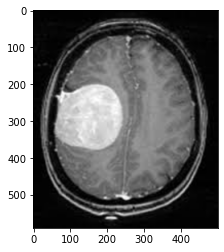

In [3]:
img_path = 'navoneel_brain_set/yes/Y1.jpg'
image = cv2.imread(img_path)
print('width: {} pixels'.format(image.shape[1]))
print('height: {} pixels'.format(image.shape[0]))
print('channels: {}'.format(image.shape[2]))
dim=(500,590)                                                       #pixel size adjusting
image=cv2.resize(image, dim)
plt.imshow(image)
plt.show()

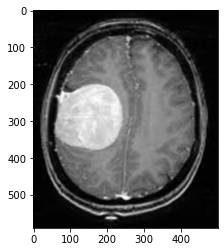

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7)
plt.imshow(gray,cmap='gray')

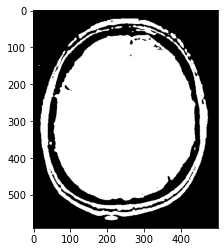

In [5]:
(T, thresh) = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
plt.imshow(thresh,cmap='gray')

In [6]:
#(T, threshInv) = cv2.threshold(gray, 115, 255,cv2.THRESH_BINARY_INV)
#plt.imshow(threshInv,cmap='gray')

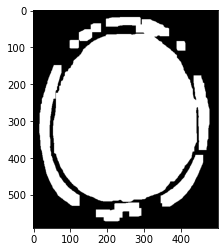

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
closed = cv2.erode(closed, None, iterations = 6)
closed = cv2.dilate(closed, None, iterations = 10)
plt.imshow(closed,cmap='gray')

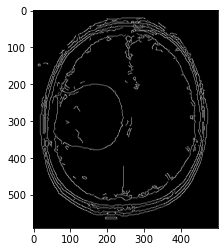

In [8]:
def auto_canny(image, sigma=0.33):
  # compute the median of the single channel pixel intensities
  v = np.median(image)
  # apply automatic Canny edge detection using the computed median
  lower = int(max(0, (1.0 - sigma) * v))
  upper = int(min(255, (1.0 + sigma) * v))
  edged = cv2.Canny(image, lower, upper)
  # return the edged image
  return edged
canny = auto_canny(image)
plt.imshow(canny,cmap='gray')

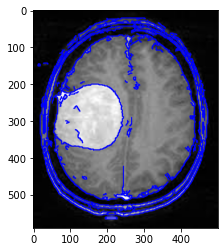

In [9]:
cnts,_ = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt_image = image.copy()
cv2.drawContours(cnt_image, cnts, -1, (0, 0, 255), 2)
plt.imshow(cnt_image,cmap='gray')

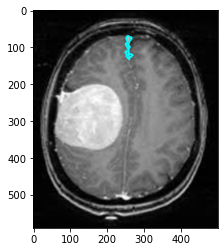

In [10]:
# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)
plt.imshow(img_cnt,cmap='gray')


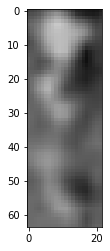

In [11]:
# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
plt.imshow(new_img,cmap='gray')

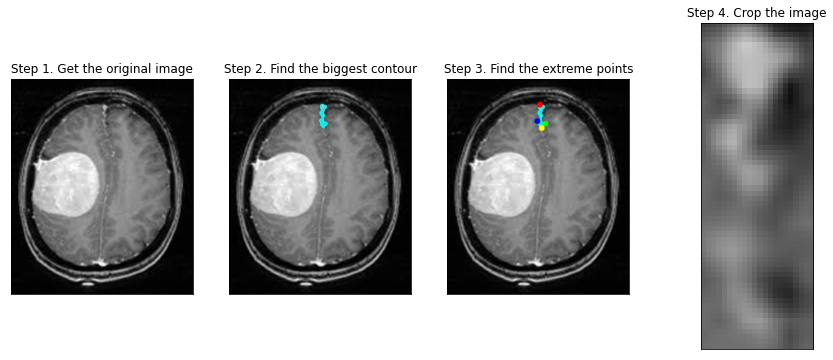

In [12]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

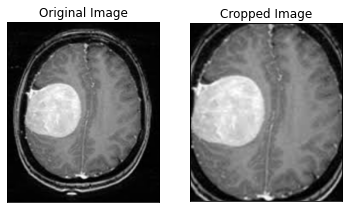

In [13]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

x_crop_img = crop_brain_contour(image, True)